# Experiment #1 - Baseline Model vs. Baseline ML Models

## Overview

The purpose of this experiment is to establish a baseline for a domain-driven model and to compare it to more sophisticated machine learning models using baseline features. Our baseline model will simply follow our intuited rule:

> Include the customer if they belong to tiers S or A, hence we are selecting 475 possible customers, which sounds a reasonable amount of customers to be reached in a certain period of time.

To estimate the performance of machine learning models, we will train the following models with some different hyperparameter configurations, selecting the best configuration and averaging the scores of the best models:

* Naive Bayes (XXXX)
* Decision tree  (XXXX)
* Logististic regression (XXXX)
* Neural network
* SVM (XXXX)

Scores will be based on how well a classifier can prioritize 475 customers considering the entire database.

In [1]:
%load_ext autoreload
%autoreload 2

from utils import code
from plot_libraries import setup_graphics
from datasets import get_data

In [2]:
# load libraries and set plot parameters
import os, random, re, sys, time, warnings
import math
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

sns.set()
warnings.filterwarnings("ignore")
pd.options.display.max_columns = None
%matplotlib inline
setup_graphics()

In [131]:
import scikitplot as skplt

#Data transform (pipeline)
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.preprocessing import MinMaxScaler,RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer


# Model evaluation
from sklearn.metrics import make_scorer, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_predict
from evaluation import plot_learning_curve, evaluate_model, plot_confusion_matrix

# Support
import parameters as params
from model import Model, build_tuned_model
from datasets import get_data
from experiments import experiment_1, get_scorer

## Data

In [4]:
X, y = get_data('../data/trainDF.csv')
X.head()

,Activities_Last_30_Days,Employees,ZoomInfo_Employee_Range,ZoomInfo_Revenue_Range,Organic_Visits,Pct_Organic_Visits,SEO_Visits,URLs_Indexed,ZoomInfo_Global_HQ_Country,Annual_Revenue_converted,Adjusted_Industry,Account_ICP_Score,Account_ICP_Tier,Page_Count,Page_Count_Range,Alexa_Rank,Parent_Account_Status
Account_ID,,,,,,,,,,,,,,,,,
0012400000L5cmZ,0.0,10.0,unknown,unknown,61688430.0,0.34,61688430.0,27700000.0,non_US,3.333900e+06,Retail,91.667,Tier A,27700000.0,>1M,331.0,unknown
00124000004sEH5,51.0,10000.0,unknown,unknown,19397082.0,0.93,28615923.0,76200.0,non_US,1.333560e+10,Retail,100.000,Tier A,206300.0,Between 100K and 250K,8881.0,Prospect
00124000004sUGG,0.0,5000.0,unknown,unknown,49283858.0,0.53,50132407.0,12600000.0,non_US,5.556500e+08,Media,100.000,Tier A,12709000.0,>1M,1118.0,Lost Customer
0011p00002SeaiQ,0.0,383.0,250 - 500,$50 mil. - $100 mil.,177515.0,NaN,177515.0,1090000.0,US,7.360000e+07,Classified,70.833,Tier A,1090000.0,>1M,126905.0,unknown
0011p00001SghSL,0.0,5000.0,"1,000 - 5,000",$500 mil. - $1 bil.,8052961.0,0.59,10416602.0,2340000.0,US,2.500000e+08,Classified,100.000,Tier A,3640000.0,>1M,4742.0,Prospect


In [153]:
n_instances = len(X)
p_instances = y.sum() / len(y)
p_targeted = 475/n_instances
n_targeted = int(n_instances*p_targeted)

print('Number of instances: {:,}'.format(n_instances))
print('Number of conversions {:,}'.format(y.sum()))
print('Conversion rate: {:.2f}%'.format(p_instances*100.))
print('Expected number of conversions targetting tiers S&A ({:,}) @ {:.2f}%: {:,}'.format(n_targeted, p_instances*100., int(p_instances * n_targeted)))

Number of instances: 1,849
Number of conversions 315
Conversion rate: 17.04%
Expected number of conversions targetting tiers S&A (475) @ 17.04%: 80


### Split Dataset

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=1)
n_targeted_test = int(len(X_test) * p_targeted)

### Baseline Model

To evaluate our baseline model, we will include some financial features, which will allow us to compare with ML models later.

In [7]:
# Setup costs and benefits
avg_revenue = params.AVG_REVENUE
avg_cost = params.AVG_COST

In [8]:
# Get all of the instances with tiers S&A
X_test_SA = X_test[X_test.Account_ICP_Tier.isin(['Tier S', 'Tier A'])]

# Calcuate how many more instances we need
n_rest = n_targeted_test - len(X_test_SA)

# Randomly choose from the remaining instances
rest = X_test[~(X_test.index.isin(X_test_SA.index))].sample(n=n_rest, random_state=1)

In [9]:
# Combine the targeted and random groups
baseline_targets = pd.concat([X_test_SA, rest], axis=0)
baseline_ys = y_test.loc[baseline_targets.index]
baseline_outcomes = baseline_ys.apply(lambda x: avg_cost if x == 0 else avg_cost + avg_revenue)
assert(len(baseline_targets) == n_targeted_test)

In [10]:
# Create the random targets
random_targets = X_test.sample(n=n_targeted_test)
random_ys = y.loc[random_targets.index]
random_outcomes = random_ys.apply(lambda x: avg_cost if x == 0 else avg_cost + avg_revenue)

In [11]:
# Compute profit
random_profit = sum(random_outcomes)
baseline_profit = sum(baseline_outcomes)

print('Number of customers targeted: {:,}/{:,}\n'.format(len(baseline_targets), len(X_test)))

print('Conversion rate under random policy: {:.1f}%'.format(random_ys.sum() / len(random_ys)*100.))
print('Expected profit under random policy: ${:,}\n'.format(random_profit))

print('Conversion rate under baseline policy: {:.3}%'.format(baseline_ys.sum() / len(baseline_ys)*100.))
print('Expected profit under baseline policy: ${:,}'.format(baseline_profit))
print('Lift over random policy: {:.1f} or ${:,}'.format(baseline_profit / random_profit, baseline_profit - random_profit))

Number of customers targeted: 95/370

Conversion rate under random policy: 12.6%
Expected profit under random policy: $11,050

Conversion rate under baseline policy: 25.3%
Expected profit under baseline policy: $23,050
Lift over random policy: 2.1 or $12,000


--------
--------

### Baseline ML models
We will evaluate some ML models and choose the best one under a score function then analyze its predictions and estimate financial impact.

From previous step, we noticed that some trasformations are necessary to improve our ML models.

##### Fill nan values (however some models are robust to this issue).

* #1 - fill_value=nan (*only valid to XGB & LGBM*)

```python
cat_ct = ColumnTransformer([('numerics', 'passthrough', experiment_1.NUM_FEAT)])
```
--------

* #2 - fill_value=-1, let the model find out a pattern from its own (**best choice**)

```python
num_ct = ColumnTransformer([
    ('fill_diff', SimpleImputer(missing_values=np.nan, strategy='constant',fill_value=-1),experiment_1.NUM_FEAT)                          
])
```
--------

* #3 - Multiple heuristics

```python
num_ct_ = ColumnTransformer([
    ('numerics', 'passthrough', pass_feat),
    ('fill_diff',SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-1),fill_diff),
    ('fill_max', SimpleImputer(missing_values=np.nan, strategy='most_frequent'),fill_max),
    ('fill_min', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0),fill_min)
])
```
-------


#### Creating the pipeline of first experiment

In [12]:
# Create the transformers for categorical features
cat_ct = ColumnTransformer([('categoricals', 'passthrough', experiment_1.CAT_FEAT)])

# Create the pipeline to transform categorical features
cat_pipeline = Pipeline([
        ('cat_ct', cat_ct),
        ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

In [13]:
# Create the transformers for numeric features
num_ct = ColumnTransformer([
    ('fill_diff', SimpleImputer(missing_values=np.nan, strategy='constant',fill_value=-1),experiment_1.NUM_FEAT)                          
])

# Create the pipeline to transform numeric features
num_pipeline = Pipeline([
        ('num_union', num_ct),
        ('scaler', RobustScaler()),
        ('minimax', MinMaxScaler())
])

Concat both pipelines and transform

In [14]:
pipeline1 = experiment_1.get_pipeline(cat_pipeline, num_pipeline)
ps = pipeline1.fit_transform(X).shape
print('Instances: {:,}, Features: {}'.format(ps[0], ps[1]))

Instances: 1,849, Features: 63


##### Evaluation Metric

In [15]:
scorer = get_scorer()
scorer

make_scorer(roc_auc_score)

In [16]:
results=[]

#### ML Models

Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression
lr_param_grid = {
  'lr__C': np.logspace(-3, 2, 6),
  'lr__intercept_scaling': [1], 
  'lr__max_iter': [100],
  'lr__penalty':  ['l1', 'l2'],
  'lr__solver': ['liblinear'], #good for small datasets
  'lr__tol': [0.0001]
}


#0.593
result = evaluate_model(X, y, 'lr', LogisticRegression(), lr_param_grid, scorer, n_iter=20, cv_folds=5, pipeline=pipeline1)
results.append(result)

==> Starting 5-fold cross validation for lr model, 1849 examples
==> Elapsed seconds: 6.040
Best lr model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
Best lr score: 0.593


XGBoost

In [18]:
from xgboost import XGBClassifier
xgb_param_grid = {
        'xgb__colsample_bylevel' : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0],
        'xgb__colsample_bytree' :[0.6, 0.7, 0.8, 1.0],
        'xgb__gamma' : list(np.linspace(0.05, 1, 6)),
        'xgb__learning_rate' : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
        'xgb__max_depth' : list(range(3, 30, 3)),
        'xgb__min_child_weight' : list(range(1, 11, 2)),
        'xgb__n_estimators' : list(range(50, 400, 50)),
        'xgb__reg_alpha' : list(np.logspace(-1, 1, num=10)/10),
        'xgb__reg_lambda' : list(np.logspace(-1, 1, num=10)/10),
        'xgb__subsample' : [0.6, 0.7, 0.8, 1.0]
}

#.668
result = evaluate_model(X, y, 'xgb', XGBClassifier(), xgb_param_grid, scorer, n_iter=10, cv_folds=5, pipeline=pipeline1)
results.append(result)

==> Starting 5-fold cross validation for xgb model, 1849 examples
==> Elapsed seconds: 13.191
Best xgb model: XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=0.7,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.24, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.2, max_delta_step=0, max_depth=6,
              min_child_weight=9, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0,
              reg_alpha=0.12915496650148842, reg_lambda=0.5994842503189408,
              scale_pos_weight=1, subsample=0.7, tree_method=None,
              validate_parameters=False, verbosity=None)
Best xgb score: 0.666


Light GBM

In [19]:
from lightgbm import LGBMClassifier
lgbm_param_grid = {
    'lgbm__boosting_type': ['gbdt', 'goss', 'dart'],
    'lgbm__num_leaves': list(range(20, 150)),
    'lgbm__learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)),
    'lgbm__subsample_for_bin': list(range(20000, 300000, 20000)),
    'lgbm__min_child_samples': list(range(20, 500, 5)),
    'lgbm__reg_alpha': list(np.linspace(0, 1)),
    'lgbm__reg_lambda': list(np.linspace(0, 1)),
    'lgbm__colsample_bytree': list(np.linspace(0.6, 1, 10)),
    'lgbm__subsample': list(np.linspace(0.5, 1, 100)),
    'lgbm__is_unbalance': [True, False]
}

#0.739
result = evaluate_model(X, y, 'lgbm', LGBMClassifier(), lgbm_param_grid, scorer, n_iter=10, cv_folds=5, pipeline=pipeline1)
results.append(result)

==> Starting 5-fold cross validation for lgbm model, 1849 examples
==> Elapsed seconds: 2.816
Best lgbm model: LGBMClassifier(boosting_type='goss', class_weight=None,
               colsample_bytree=0.8666666666666667, importance_type='split',
               is_unbalance=True, learning_rate=0.15362344213545015,
               max_depth=-1, min_child_samples=165, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=70,
               objective=None, random_state=None, reg_alpha=0.3469387755102041,
               reg_lambda=0.7551020408163265, silent=True,
               subsample=0.8131313131313131, subsample_for_bin=20000,
               subsample_freq=0)
Best lgbm score: 0.715


SGD Classifier

In [20]:
from sklearn.linear_model import SGDClassifier
sgd_param_grid = {
  'sgd__alpha' : np.logspace(-4, 3, 8), 
  'sgd__loss' : ['log'], #['log','hinge'],
  'sgd__max_iter' : [1000],  
  'sgd__n_jobs' : [-1], 
  'sgd__penalty' : ['l2', 'l1', 'elasticnet'],
  'sgd__tol' : [0.001],
}


#0.606
result = evaluate_model(X, y, 'sgd', SGDClassifier(), sgd_param_grid, scorer, n_iter=10, cv_folds=5, pipeline=pipeline1)
results.append(result)

==> Starting 5-fold cross validation for sgd model, 1849 examples
==> Elapsed seconds: 1.355
Best sgd model: SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=-1, penalty='elasticnet', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Best sgd score: 0.593


Knn

In [21]:
from sklearn.neighbors import KNeighborsClassifier
knn_param_grid =  {
  'knn__leaf_size' : list(range(2, 40, 2)), 
  'knn__metric' : ['euclidean', 'manhattan'],
  'knn__n_neighbors' : list(range(2, 18, 2)), 
  'knn__p' : [2,3],
  'knn__weights' : ['uniform', 'distance']
}

#0.526
result = evaluate_model(X, y, 'knn', KNeighborsClassifier(), knn_param_grid, scorer, n_iter=10, cv_folds=5, pipeline=pipeline1)
results.append(result)

==> Starting 5-fold cross validation for knn model, 1849 examples
==> Elapsed seconds: 10.024
Best knn model: KNeighborsClassifier(algorithm='auto', leaf_size=8, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=3,
                     weights='uniform')
Best knn score: 0.526


### Comparing results

In [59]:
pd.DataFrame.from_dict(list(map(lambda x:
                      {'model': x[1], 'mean': x[2], 'std': x[3] }, results)))[[
                       'model', 'mean', 'std'
                      ]].sort_values('mean', ascending=False).style.bar()

,model,mean,std
2,lgbm,0.715357,0.061716
1,xgb,0.665906,0.064521
0,lr,0.592771,0.057784
3,sgd,0.592592,0.050316
4,knn,0.526450,0.051825


In [100]:
model_result = list(filter(lambda x: x[1] == 'lgbm', results))[0]
model = model_result[0]
print('Best model performance mean:', model_result[2])
print('Best model performance std:', model_result[3])
#model.save('../models_pkl/experiment-1-model.pkl')

Best model performance mean: 0.7153571719016798
Best model performance std: 0.06171638033943343


--------------
-------------

### Analyzing best model

In [117]:
model = Model.load('../models_pkl/experiment-1-model.pkl')
model.model

LGBMClassifier(boosting_type='goss', class_weight=None,
               colsample_bytree=0.8666666666666667, importance_type='split',
               is_unbalance=True, learning_rate=0.15362344213545015,
               max_depth=-1, min_child_samples=165, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=70,
               objective=None, random_state=None, reg_alpha=0.3469387755102041,
               reg_lambda=0.7551020408163265, silent=True,
               subsample=0.8131313131313131, subsample_for_bin=20000,
               subsample_freq=0)

We can see that our best model performs worst than a random model when we have only 10% of our data (i.e AUC=0.5), however the performance comes better as the dataset size increase, it also suffers with high variance on validation score (such as linear models). The last two statements indicates that we may need more data. 

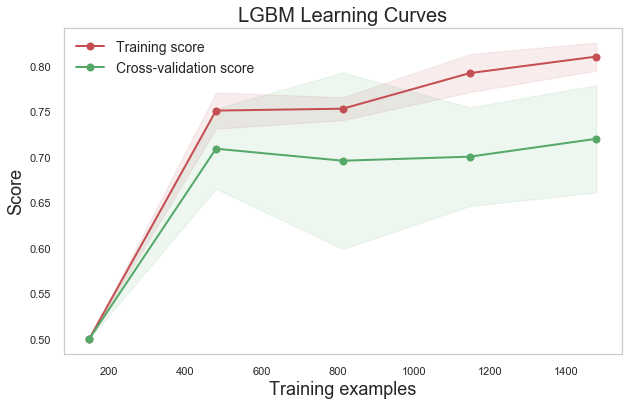

In [101]:
plot_learning_curve(model.model, 
                    model.name.upper()+' Learning Curves',
                    model.pipeline.fit_transform(X), y,
                    cv=5, scoring=scorer)

------------

In [160]:
y.sum()

315

In [ ]:
#precisao da classe 1 baixa

In [149]:
preds = cross_val_predict(model.get_model_pipeline(), X, y, cv=5)

              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1534
           1       0.32      0.68      0.44       315

    accuracy                           0.70      1849
   macro avg       0.62      0.69      0.62      1849
weighted avg       0.81      0.70      0.74      1849



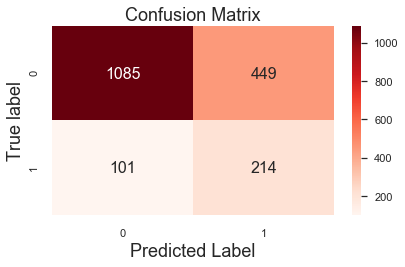

In [150]:
plot_confusion_matrix(y, preds)

              precision    recall  f1-score   support

           0       0.97      0.81      0.88       307
           1       0.49      0.89      0.63        63

    accuracy                           0.82       370
   macro avg       0.73      0.85      0.76       370
weighted avg       0.89      0.82      0.84       370



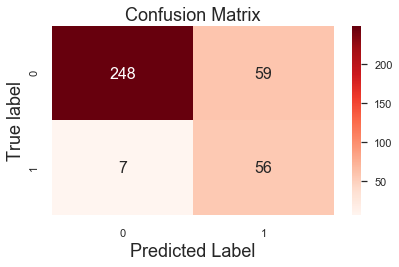

In [162]:
probs = model.model.predict_proba(model.pipeline.transform(X_test))
preds = model.model.predict(model.pipeline.transform(X_test))
plot_confusion_matrix(y_test, preds)

In [143]:
_ = skplt.metrics.cumulative_gain_curve(y_test, probs)

In [106]:
# Create a dataframe of probabilities and actual / predicted outcomes
probs_df = pd.DataFrame(np.hstack([probs, y_test.values.reshape(-1,1), preds.reshape(-1,1)]), 
                        columns=['p_no', 'p_yes', 'actual', 'predicted'])


# Sort customers by the probability that they will convert
model_targets = probs_df.sort_values('p_yes', ascending=False)

# Take the top 25%
model_targets = model_targets.head(n_targeted_test)

# Calculate financial outcomes
model_outcomes = model_targets.actual.apply(lambda x: avg_cost if x == 0 else avg_cost + avg_revenue)

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        44
         1.0       0.54      1.00      0.70        51

    accuracy                           0.54        95
   macro avg       0.27      0.50      0.35        95
weighted avg       0.29      0.54      0.38        95



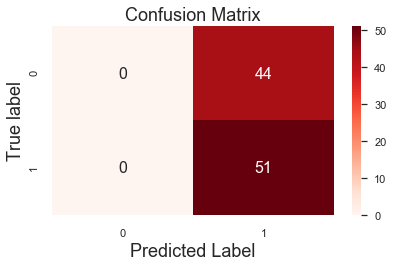

In [147]:
plot_confusion_matrix(model_targets.actual, model_targets.predicted)

In [ ]:
#PDP SHAP

In [166]:
95/475

0.2

In [178]:
model_targets.tail(10)

,p_no,p_yes,actual,predicted
86,0.352536,0.647464,0.0,1.0
148,0.353767,0.646233,0.0,1.0
93,0.362164,0.637836,0.0,1.0
282,0.372531,0.627469,0.0,1.0
248,0.381985,0.618015,1.0,1.0
270,0.382470,0.617530,0.0,1.0
339,0.390917,0.609083,0.0,1.0
185,0.399240,0.600760,0.0,1.0
212,0.400262,0.599738,0.0,1.0
348,0.408327,0.591673,0.0,1.0


In [176]:
len(X_test)*0.25

92.5

In [175]:
63/370

475/1849

0.2568956192536506

In [172]:
y_test.sum()

63

### Financial Impact of the Best Model

In [108]:
# Calculate profit
model_profit = sum(model_outcomes)

print('Number of customers targeted: {:,}/{:,}'.format(len(model_targets), len(X_test)))
print('Conversion rate of model policy: {:.2f}%'.format(model_targets.actual.sum() / len(model_outcomes)*100.))
print('Expected profit of model policy: ${:,}'.format(model_profit))
print('Lift over random: {:.1f} or ${:,}'.format(model_profit / random_profit, model_profit - random_profit))
print('Lift over baseline: {:.1f} or ${:,}'.format(model_profit / baseline_profit, model_profit - baseline_profit))

Number of customers targeted: 95/370
Conversion rate of model policy: 53.68%
Expected profit of model policy: $50,050
Lift over random: 4.5 or $39,000
Lift over baseline: 2.2 or $27,000
